# Car valuation

Описание данных

- `id`: идентификатор записи;
- `url`: URL записи о продаже;
- `region`: регион;
- `region_url`: URL региона;
- `price`: стоимость;
- `year`: год выпуска;
- `manufacturer`: производитель;
- `model`: модель;
- `fuel`: тип топлива;
- `odometer`: количество пройденных миль;
- `title_status`: статус;
- `transmission`: коробка передач;
- `image_url`: URL изображения;
- `description`: указанное описание;
- `state`: штат;
- `lat`: широта;
- `long`: долгота;
- `posting_date`: дата размещения объявления о продаже;
- `price_category`: категория цены;
- `year`: год.

In [493]:
import pandas as pd
import numpy as np
import missingno as msno
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score 
from sklearn.metrics import accuracy_score, confusion_matrix 
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier



## Загрузка данных

In [312]:
#снимем ограничение на количество отображаемых столбцов

pd.options.display.max_columns = None

In [431]:
df = pd.read_csv('vehicles_dataset.csv')
print(df.shape)
df.head()

(10000, 20)


,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442,clean,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,60023,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,gas,14048,clean,other,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013.0,toyota,rav4,gas,117291,clean,automatic,https://images.craigslist.org/00606_iGe5iXidib...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021.0,nissan,altima,gas,8000,clean,automatic,https://images.craigslist.org/00V0V_3pSOiPZ3Sd...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00


## *Data preparation*

### Обработка типов данных

In [432]:
# Пропуски есть у 11 признаков, много признаков содержит тип object
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   url             10000 non-null  object 
 2   region          10000 non-null  object 
 3   region_url      10000 non-null  object 
 4   price           10000 non-null  int64  
 5   year            9964 non-null   float64
 6   manufacturer    10000 non-null  object 
 7   model           9872 non-null   object 
 8   fuel            9937 non-null   object 
 9   odometer        10000 non-null  int64  
 10  title_status    9834 non-null   object 
 11  transmission    9955 non-null   object 
 12  image_url       9998 non-null   object 
 13  description     9998 non-null   object 
 14  state           10000 non-null  object 
 15  lat             9902 non-null   float64
 16  long            9902 non-null   float64
 17  posting_date    9998 non-null   

In [433]:
# Заменим тип object на наиболее подходящие
df = df.convert_dtypes()

In [434]:
# метод convert_dtypes() не работает для типа временных данных, поэтому заменим отдельно
df.date = pd.to_datetime(df.date)
df.posting_date = pd.to_datetime(df.posting_date, utc = True)

In [435]:
# после приведения к одному типу, определим различаются ли столбцы date и posting_date
df[df.posting_date == df.date].shape



(9998, 20)

In [436]:
# это один признак, удалим лишний столбец
df = df.drop(['date'], axis = 1)

In [437]:
# проверим получившиеся типы данных
df.dtypes

id                              Int64
url                            string
region                         string
region_url                     string
price                           Int64
year                            Int64
manufacturer                   string
model                          string
fuel                           string
odometer                        Int64
title_status                   string
transmission                   string
image_url                      string
description                    string
state                          string
lat                           Float64
long                          Float64
posting_date      datetime64[ns, UTC]
price_category                 string
dtype: object

### Обработка пропусков в данных

In [438]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              10000 non-null  Int64              
 1   url             10000 non-null  string             
 2   region          10000 non-null  string             
 3   region_url      10000 non-null  string             
 4   price           10000 non-null  Int64              
 5   year            9964 non-null   Int64              
 6   manufacturer    10000 non-null  string             
 7   model           9872 non-null   string             
 8   fuel            9937 non-null   string             
 9   odometer        10000 non-null  Int64              
 10  title_status    9834 non-null   string             
 11  transmission    9955 non-null   string             
 12  image_url       9998 non-null   string             
 13  description     9998 non-null   

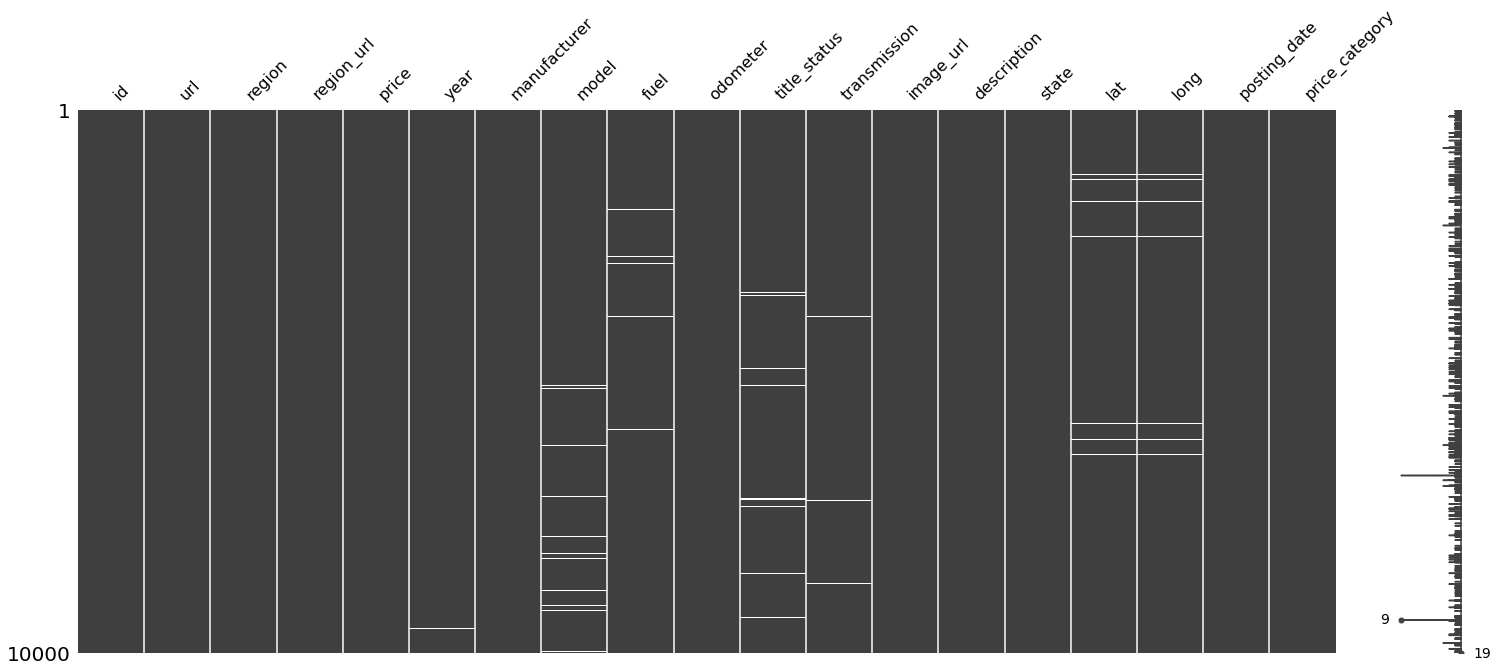

In [439]:
msno.matrix(df);

В данных не много пропусков, менее 20% на признак, поэтому численные пропуски заменим на медиану, а качественные - на моду или новое значение 'other'

In [440]:
# числовые значения заменим на медиану
num_values = ('year', 'lat', 'long')
for column in num_values:
    df[column] = df[column].fillna(df[column].median())
    

In [441]:
df.title_status.value_counts()

clean         9518
rebuilt        171
salvage         92
lien            35
missing         16
parts only       2
Name: title_status, dtype: Int64

In [442]:
# Заменим качественные переменные на other
qual_var = ('model', 'fuel', 'title_status', 'transmission', 'image_url', 'description')
for column in qual_var:
    df[column] = df[column].fillna('other')

In [443]:
# заменим временные данные на моду
d_mode = df.posting_date.mode().squeeze()
df['posting_date'] = df['posting_date'].fillna(d_mode)

In [444]:
df.posting_date = pd.to_datetime(df.posting_date, utc = True)

In [445]:
# Проверим теперь пропуски
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              10000 non-null  Int64              
 1   url             10000 non-null  string             
 2   region          10000 non-null  string             
 3   region_url      10000 non-null  string             
 4   price           10000 non-null  Int64              
 5   year            10000 non-null  Int64              
 6   manufacturer    10000 non-null  string             
 7   model           10000 non-null  string             
 8   fuel            10000 non-null  string             
 9   odometer        10000 non-null  Int64              
 10  title_status    10000 non-null  string             
 11  transmission    10000 non-null  string             
 12  image_url       10000 non-null  string             
 13  description     10000 non-null  

### Проверка данных на аномалии и дубликаты

In [446]:
# проверим данные на наличие дубликатов
df[df.duplicated()].shape

(0, 19)

In [447]:
# проверим данные на выборосы
# Посмотрим, какие есть численные данные
df.select_dtypes(include = np.number).head()

,id,price,year,odometer,lat,long
0,7308295377,54990,2020,27442,35.06,-85.25
1,7316380095,16942,2016,60023,40.821805,-74.061962
2,7313733749,35590,2017,14048,33.779214,-84.411811
3,7308210929,14500,2013,117291,35.715954,-78.655304
4,7316474668,21800,2021,8000,40.6548,-73.6097


In [448]:
# Оценим, в каких атрибутах есть выбросы
df.describe()

,id,price,year,odometer,lat,long
count,1.000000e+04,1.000000e+04,10000.00000,10000.00000,10000.000000,10000.000000
mean,7.311541e+09,2.067842e+04,2010.93540,93324.13400,38.601045,-94.105452
std,4.477653e+06,1.246230e+05,9.65541,63181.17499,5.816596,18.049670
min,7.208550e+09,5.000000e+02,1915.00000,0.00000,-67.144243,-158.069300
25%,7.308189e+09,7.900000e+03,2008.00000,39147.25000,34.920000,-108.558634
50%,7.312757e+09,1.574950e+04,2013.00000,89000.00000,39.298522,-88.000050
75%,7.315274e+09,2.799000e+04,2017.00000,136875.00000,42.381700,-80.998136
max,7.317090e+09,1.234568e+07,2022.00000,283466.00000,64.947500,173.885502


In [449]:
# Посмотрим процент выбросов для price
irq = df.describe().loc['75%', 'price'] - df.describe().loc['25%', 'price']
boundaries = (df.describe().loc['25%', 'price'] - 1.5*irq, df.describe().loc['75%', 'price'] + 1.5*irq)
len(df[((df.price < boundaries[0]) | (df.price > boundaries[1]))])/len(df) * 100

2.15

In [450]:
# заменим эти выбросы граничными значениями
df.price = df.price.clip(boundaries[0], boundaries[1])

In [451]:
len(df[((df.price < boundaries[0]) | (df.price > boundaries[1]))])/len(df) * 100

0.0

In [452]:
# Посмотрим процент выбросов для year
irq = df.describe().loc['75%', 'year'] - df.describe().loc['25%', 'year']
boundaries = (df.describe().loc['25%', 'year'] - 1.5*irq, df.describe().loc['75%', 'year'] + 1.5*irq)
len(df[((df.year < boundaries[0]) | (df.year > boundaries[1]))])/len(df) * 100

3.94

In [453]:
# Заменим эти значения 
df.year = df.year.clip(int(boundaries[0]), int(boundaries[1]))

In [454]:
# Посмотрим процент выбросов для odometer
irq = df.describe().loc['75%', 'odometer'] - df.describe().loc['25%', 'odometer']
boundaries = (df.describe().loc['25%', 'odometer'] - 1.5*irq, df.describe().loc['75%', 'odometer'] + 1.5*irq)
len(df[((df.odometer < boundaries[0]) | (df.odometer > boundaries[1]))])/len(df) * 100

0.0

In [455]:
# Посмотрим процент выбросов для lat
irq = df.describe().loc['75%', 'lat'] - df.describe().loc['25%', 'lat']
boundaries = (df.describe().loc['25%', 'lat'] - 1.5*irq, df.describe().loc['75%', 'lat'] + 1.5*irq)
len(df[((df.lat < boundaries[0]) | (df.lat > boundaries[1]))])/len(df) * 100

1.43

In [456]:
df.lat = df.lat.clip(boundaries[0], boundaries[1])

In [457]:
# Посмотрим процент выбросов для long
irq = df.describe().loc['75%', 'long'] - df.describe().loc['25%', 'long']
boundaries = (df.describe().loc['25%', 'long'] - 1.5*irq, df.describe().loc['75%', 'long'] + 1.5*irq)
len(df[((df.long < boundaries[0]) | (df.long > boundaries[1]))])/len(df) * 100

0.63

In [458]:
df.long = df.long.clip(boundaries[0], boundaries[1])

## Feature engineering

### Преобразование категориальных переменных

In [459]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'fuel', 'odometer', 'title_status', 'transmission',
       'image_url', 'description', 'state', 'lat', 'long', 'posting_date',
       'price_category'],
      dtype='object')

In [460]:
# Признаки url, image_url и region_url не информативны для построения модели, удалим их
df = df.drop(columns=['url', 'region_url', 'image_url'], axis = 1)

In [461]:
# Преобразуем переменную description, укажем только длину этого признака
df['len_description'] = df.description.apply(lambda x: len(x))

In [462]:
# название моделей слишком длинные, развернутые, посмотрим количество уникальных
df.model.nunique()

3467

In [463]:
# попробуем сократить, выбрав только первое слово
df['short_model'] = df.apply(lambda x: x.model.split()[0], axis = 1)

In [464]:
# тогда количество уникальных 
df.short_model.nunique()

989

In [465]:
# Имеются следующие категориальные переменные

data_cat = ('region', 'manufacturer', 'short_model', 'fuel', 'title_status', 'transmission', 'state')

In [466]:
ohe = OneHotEncoder(sparse = False)
ohe.fit(df[['region', 'manufacturer', 'short_model', 'fuel', 'title_status', 'transmission', 'state']])
ohe_data = ohe.transform(df[['region', 'manufacturer', 'short_model', 'fuel', 'title_status', 'transmission', 'state']])
df[ohe.get_feature_names()] = ohe_data

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [467]:
df.head()

,id,region,price,year,manufacturer,model,fuel,odometer,title_status,transmission,description,state,lat,long,posting_date,price_category,len_description,short_model,x0_SF bay area,x0_abilene,x0_akron / canton,x0_albany,x0_albuquerque,x0_altoona-johnstown,x0_amarillo,x0_ames,x0_anchorage / mat-su,x0_ann arbor,x0_annapolis,x0_appleton-oshkosh-FDL,x0_asheville,x0_ashtabula,x0_athens,x0_atlanta,x0_auburn,x0_augusta,x0_austin,x0_bakersfield,x0_baltimore,x0_baton rouge,x0_battle creek,x0_beaumont / port arthur,x0_bellingham,x0_bemidji,x0_bend,x0_billings,x0_binghamton,x0_birmingham,x0_bismarck,x0_bloomington,x0_bloomington-normal,x0_boise,x0_boone,x0_boston,x0_boulder,x0_bowling green,x0_bozeman,x0_brainerd,x0_brownsville,x0_brunswick,x0_buffalo,x0_butte,x0_cape cod / islands,x0_catskills,x0_cedar rapids,x0_central NJ,x0_central louisiana,x0_central michigan,x0_champaign urbana,x0_charleston,x0_charlotte,x0_charlottesville,x0_chattanooga,x0_chautauqua,x0_chicago,x0_chico,x0_chillicothe,x0_cincinnati,x0_clarksville,x0_cleveland,x0_clovis / portales,x0_college station,x0_colorado springs,x0_columbia,x0_columbia / jeff city,x0_columbus,x0_corpus christi,x0_corvallis/albany,x0_cumberland valley,x0_dallas / fort worth,x0_danville,x0_dayton / springfield,x0_daytona beach,x0_decatur,x0_del rio / eagle pass,x0_delaware,x0_denver,x0_des moines,x0_detroit metro,x0_dothan,x0_dubuque,x0_duluth / superior,x0_east idaho,x0_east oregon,x0_eastern CO,x0_eastern CT,x0_eastern NC,x0_eastern kentucky,x0_eastern montana,x0_eastern panhandle,x0_eastern shore,x0_eau claire,x0_el paso,x0_elko,x0_elmira-corning,x0_erie,x0_eugene,x0_evansville,x0_fairbanks,x0_fargo / moorhead,x0_farmington,x0_fayetteville,x0_finger lakes,x0_flagstaff / sedona,x0_flint,x0_florence,x0_florence / muscle shoals,x0_florida keys,x0_fort collins / north CO,x0_fort dodge,x0_fort smith,x0_fort wayne,x0_frederick,x0_fredericksburg,x0_fresno / madera,x0_ft myers / SW florida,x0_gadsden-anniston,x0_gainesville,x0_galveston,x0_glens falls,x0_gold country,x0_grand forks,x0_grand island,x0_grand rapids,x0_great falls,x0_green bay,x0_greensboro,x0_greenville / upstate,x0_gulfport / biloxi,x0_hanford-corcoran,x0_harrisburg,x0_harrisonburg,x0_hartford,x0_hattiesburg,x0_hawaii,x0_heartland florida,x0_helena,x0_hickory / lenoir,x0_high rockies,x0_hilton head,x0_holland,x0_houma,x0_houston,x0_hudson valley,x0_humboldt county,x0_huntington-ashland,x0_huntsville / decatur,x0_imperial county,x0_indianapolis,x0_inland empire,x0_iowa city,x0_ithaca,x0_jackson,x0_jacksonville,x0_janesville,x0_jersey shore,x0_jonesboro,x0_joplin,x0_kalamazoo,x0_kalispell,"x0_kansas city, MO",x0_kenai peninsula,x0_kennewick-pasco-richland,x0_kenosha-racine,x0_killeen / temple / ft hood,x0_kirksville,x0_klamath falls,x0_knoxville,x0_kokomo,x0_la crosse,x0_la salle co,x0_lafayette,x0_lafayette / west lafayette,x0_lake charles,x0_lake of the ozarks,x0_lakeland,x0_lancaster,x0_lansing,x0_laredo,x0_las cruces,x0_las vegas,x0_lawrence,x0_lawton,x0_lehigh valley,x0_lewiston / clarkston,x0_lexington,x0_lima / findlay,x0_lincoln,x0_little rock,x0_logan,x0_long island,x0_los angeles,x0_louisville,x0_lubbock,x0_lynchburg,x0_macon / warner robins,x0_madison,x0_maine,x0_manhattan,x0_mankato,x0_mansfield,x0_mason city,x0_mattoon-charleston,x0_mcallen / edinburg,x0_meadville,x0_medford-ashland,x0_memphis,x0_mendocino county,x0_merced,x0_milwaukee,x0_minneapolis / st paul,x0_missoula,x0_mobile,x0_modesto,x0_mohave county,x0_monroe,x0_monterey bay,x0_montgomery,x0_morgantown,x0_moses lake,x0_muncie / anderson,x0_muskegon,x0_myrtle beach,x0_nashville,x0_new hampshire,x0_new haven,x0_new orleans,x0_new river valley,x0_new york city,x0_norfolk / hampton roads,x0_north central FL,x0_north dakota,x0_north jersey,x0_north mississippi,x0_north platte,x0_northeast SD,x0_northern WI,x0_northern michigan,x0_northern panhandle,x0_northwest CT,x0_northwest GA,x0_northwest KS,x0_northwest OK,x0_ocala,x0_odessa / midland,x0_ogden-clearfield,x0_okaloo

In [468]:
df.shape

(10000, 1506)

In [469]:
# удалим лишние столбцы, также удалим price, как связанную с целевой переменной
df = df.drop(columns=['region', 'manufacturer', 'short_model', 'fuel', 'title_status', 'transmission', 
                        'state', 'description', 'model', 'price'], axis = 1)

### Преобразование числовых переменных, Стандартизация

In [470]:
# Создадим новую фичу - количество лет, прошедших с изготовления до продажи
df['post_year'] = df.posting_date.dt.year
df['diff_year'] = df.apply(lambda x: x.post_year - x.year, axis = 1)

In [471]:
# определим числовые переменные

variables = ['year', 'odometer', 'lat', 'long', 'len_description', 'diff_year']
data_nv = df[variables]

In [472]:
scaler = MinMaxScaler()
scaler.fit(data_nv)
scaled = scaler.transform(data_nv)


In [473]:
data_nv[variables] = scaled
for var in variables:
    data_nv = data_nv.rename(columns={var: var + '_mm'})

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [474]:
df[data_nv.columns] = data_nv

In [475]:
# удалим лишние столбцы
df = df.drop(columns=variables, axis = 1)
df = df.drop(['post_year'], axis = 1)

In [476]:
# также удалим атрибут posting_date
df = df.drop(['posting_date'], axis = 1)

In [477]:
df.price_category.value_counts()

high      3495
medium    3280
low       3225
Name: price_category, dtype: Int64

In [478]:
df['price_category'] = df.price_category.apply(lambda x: 1 if x == 'low'else (2 if x == 'medium' else 3))

In [479]:
df = df.drop(['id'], axis = 1)

In [497]:
df.to_csv('df_prepared.csv', index = False)

## *Modelling*

In [480]:
df.sample()

,price_category,x0_SF bay area,x0_abilene,x0_akron / canton,x0_albany,x0_albuquerque,x0_altoona-johnstown,x0_amarillo,x0_ames,x0_anchorage / mat-su,x0_ann arbor,x0_annapolis,x0_appleton-oshkosh-FDL,x0_asheville,x0_ashtabula,x0_athens,x0_atlanta,x0_auburn,x0_augusta,x0_austin,x0_bakersfield,x0_baltimore,x0_baton rouge,x0_battle creek,x0_beaumont / port arthur,x0_bellingham,x0_bemidji,x0_bend,x0_billings,x0_binghamton,x0_birmingham,x0_bismarck,x0_bloomington,x0_bloomington-normal,x0_boise,x0_boone,x0_boston,x0_boulder,x0_bowling green,x0_bozeman,x0_brainerd,x0_brownsville,x0_brunswick,x0_buffalo,x0_butte,x0_cape cod / islands,x0_catskills,x0_cedar rapids,x0_central NJ,x0_central louisiana,x0_central michigan,x0_champaign urbana,x0_charleston,x0_charlotte,x0_charlottesville,x0_chattanooga,x0_chautauqua,x0_chicago,x0_chico,x0_chillicothe,x0_cincinnati,x0_clarksville,x0_cleveland,x0_clovis / portales,x0_college station,x0_colorado springs,x0_columbia,x0_columbia / jeff city,x0_columbus,x0_corpus christi,x0_corvallis/albany,x0_cumberland valley,x0_dallas / fort worth,x0_danville,x0_dayton / springfield,x0_daytona beach,x0_decatur,x0_del rio / eagle pass,x0_delaware,x0_denver,x0_des moines,x0_detroit metro,x0_dothan,x0_dubuque,x0_duluth / superior,x0_east idaho,x0_east oregon,x0_eastern CO,x0_eastern CT,x0_eastern NC,x0_eastern kentucky,x0_eastern montana,x0_eastern panhandle,x0_eastern shore,x0_eau claire,x0_el paso,x0_elko,x0_elmira-corning,x0_erie,x0_eugene,x0_evansville,x0_fairbanks,x0_fargo / moorhead,x0_farmington,x0_fayetteville,x0_finger lakes,x0_flagstaff / sedona,x0_flint,x0_florence,x0_florence / muscle shoals,x0_florida keys,x0_fort collins / north CO,x0_fort dodge,x0_fort smith,x0_fort wayne,x0_frederick,x0_fredericksburg,x0_fresno / madera,x0_ft myers / SW florida,x0_gadsden-anniston,x0_gainesville,x0_galveston,x0_glens falls,x0_gold country,x0_grand forks,x0_grand island,x0_grand rapids,x0_great falls,x0_green bay,x0_greensboro,x0_greenville / upstate,x0_gulfport / biloxi,x0_hanford-corcoran,x0_harrisburg,x0_harrisonburg,x0_hartford,x0_hattiesburg,x0_hawaii,x0_heartland florida,x0_helena,x0_hickory / lenoir,x0_high rockies,x0_hilton head,x0_holland,x0_houma,x0_houston,x0_hudson valley,x0_humboldt county,x0_huntington-ashland,x0_huntsville / decatur,x0_imperial county,x0_indianapolis,x0_inland empire,x0_iowa city,x0_ithaca,x0_jackson,x0_jacksonville,x0_janesville,x0_jersey shore,x0_jonesboro,x0_joplin,x0_kalamazoo,x0_kalispell,"x0_kansas city, MO",x0_kenai peninsula,x0_kennewick-pasco-richland,x0_kenosha-racine,x0_killeen / temple / ft hood,x0_kirksville,x0_klamath falls,x0_knoxville,x0_kokomo,x0_la crosse,x0_la salle co,x0_lafayette,x0_lafayette / west lafayette,x0_lake charles,x0_lake of the ozarks,x0_lakeland,x0_lancaster,x0_lansing,x0_laredo,x0_las cruces,x0_las vegas,x0_lawrence,x0_lawton,x0_lehigh valley,x0_lewiston / clarkston,x0_lexington,x0_lima / findlay,x0_lincoln,x0_little rock,x0_logan,x0_long island,x0_los angeles,x0_louisville,x0_lubbock,x0_lynchburg,x0_macon / warner robins,x0_madison,x0_maine,x0_manhattan,x0_mankato,x0_mansfield,x0_mason city,x0_mattoon-charleston,x0_mcallen / edinburg,x0_meadville,x0_medford-ashland,x0_memphis,x0_mendocino county,x0_merced,x0_milwaukee,x0_minneapolis / st paul,x0_missoula,x0_mobile,x0_modesto,x0_mohave county,x0_monroe,x0_monterey bay,x0_montgomery,x0_morgantown,x0_moses lake,x0_muncie / anderson,x0_muskegon,x0_myrtle beach,x0_nashville,x0_new hampshire,x0_new haven,x0_new orleans,x0_new river valley,x0_new york city,x0_norfolk / hampton roads,x0_north central FL,x0_north dakota,x0_north jersey,x0_north mississippi,x0_north platte,x0_northeast SD,x0_northern WI,x0_northern michigan,x0_northern panhandle,x0_northwest CT,x0_northwest GA,x0_northwest KS,x0_northwest OK,x0_ocala,x0_odessa / midland,x0_ogden-clearfield,x0_okaloosa / walton,x0_oklahoma city,x0_olympic peninsula,x0_omaha / council bluffs,x0_oneonta,x0_orange county,x0_oregon coast,x0_orlando,x0_outer banks,x0

In [481]:
# разделим датасет на предикторы и целевую переменную
x = df.drop(['price_category'], axis = 1)
y = df['price_category']

In [495]:
# объявим три модели: логистическая регрессия, случайный лес и многослойный персептрон
logreg = LogisticRegression(max_iter = 500, random_state=42)

In [483]:
MLP = MLPClassifier(max_iter=500, hidden_layer_sizes=(100, 20), activation='tanh')

In [489]:
rf_clf = RandomForestClassifier(random_state = 42)

In [496]:
# Oценим точность логистической регрессии
cv_score_lr = cross_val_score(logreg, x, y, cv = 5)
print(cv_score_lr.mean(), cv_score_lr.std())

0.7711 0.005379591062525106


Получилось 77% и отклонение 0.005, нормальный результат

In [491]:
# обучим модель случайного леса и оценим точность
cv_score_rf = cross_val_score(rf_clf, x, y, cv = 5)
print(cv_score_rf.mean(), cv_score_rf.std())

0.7807000000000001 0.0059548299723837595


Тоже хороший результат 78% и отклонение 0.005

In [490]:
# обучим модель многослойного персептрона и оценим точность
cv_score_mlp = cross_val_score(MLP, x, y, cv = 5)
print(cv_score_mlp.mean(), cv_score_mlp.std())

0.7621999999999999 0.00827405583737503


76% и отклонение 0.008

## *Results*

Лучший результат показала модель случайного леса с точностью на тестовой выборке 78%

Обучим эту модель на всей выборке

In [492]:
rf_clf.fit(x, y)

RandomForestClassifier(random_state=42)

Сохраним обученную модель в формате pickle

In [494]:
filename = 'model.pickle'

with open(filename, 'wb') as file:
  pickle.dump(rf_clf, file)